In [ ]:
!pip install --upgrade "yfinance>=0.1.70"
!pip install --upgrade "pandas>=1.3"
!pip install --upgrade "numpy>=1.22"
!pip install tqdm
!pip install arch


In [ ]:
import arch
import yfinance as yf
import numpy as np
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt

/root/venv/lib/python3.8/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [ ]:
np.__version__

'1.22.2'

# Risk Measure Validation

In [ ]:
quotes = yf.download("AAPL", "2016-01-01", "2020-12-31")
returns = quotes['Adj Close'].pct_change().dropna()
returns.head()

[*********************100%***********************]  1 of 1 completed


Date
2016-01-05   -0.025059
2016-01-06   -0.019570
2016-01-07   -0.042204
2016-01-08    0.005288
2016-01-11    0.016192
Name: Adj Close, dtype: float64

In [ ]:
# VaR estimate. We'll discuss this in more detail later
VaRs = returns.rolling(252, closed="left").apply(lambda x:-x.quantile(0.01)).dropna()
alpha = 0.99

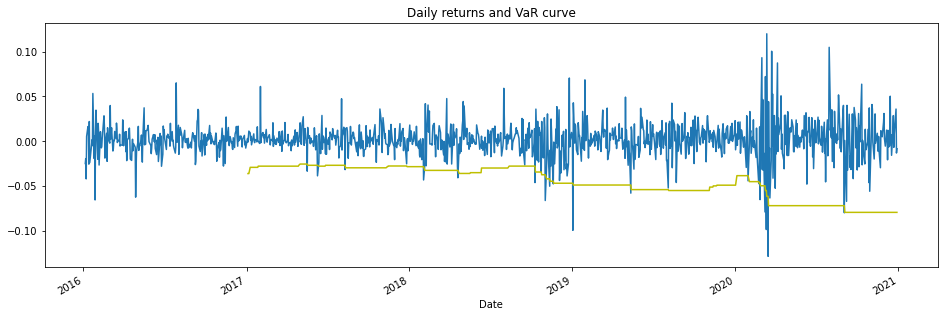

In [ ]:
plt.figure(figsize=(16,5))
returns.plot()
(-VaRs).plot(color='y')

plt.title("Daily returns and VaR curve");

In [ ]:
VaRs.head()

Date
2017-01-04    0.036269
2017-01-05    0.036269
2017-01-06    0.036269
2017-01-09    0.029306
2017-01-10    0.029306
Name: Adj Close, dtype: float64

In [ ]:
hits = returns[VaRs.index] < -VaRs
hits

Date
2017-01-04    False
2017-01-05    False
2017-01-06    False
2017-01-09    False
2017-01-10    False
              ...  
2020-12-23    False
2020-12-24    False
2020-12-28    False
2020-12-29    False
2020-12-30    False
Name: Adj Close, Length: 1005, dtype: bool

In [ ]:
hit_times = hits.index[hits]
hit_times

DatetimeIndex(['2017-05-17', '2017-06-09', '2017-08-10', '2018-02-02',
               '2018-04-20', '2018-10-10', '2018-11-02', '2018-11-12',
               '2018-11-20', '2019-01-03', '2019-05-13', '2020-01-31',
               '2020-02-24', '2020-02-27', '2020-03-09', '2020-03-12',
               '2020-03-16', '2020-09-03'],
              dtype='datetime64[ns]', name='Date', freq=None)

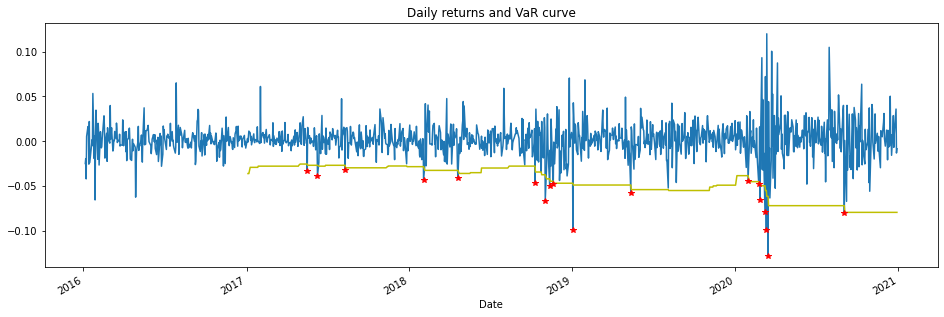

In [ ]:
plt.figure(figsize=(16,5))
returns.plot()
(-VaRs).plot(color='y')
plt.plot(hit_times, returns[hit_times], 'r*')

plt.title("Daily returns and VaR curve");

In [ ]:
N = hits.size
n = hits.sum()
N, n

(1005, 18)

In [ ]:
# Hit fraction (expected 0.01)
n / N * 100

1.791044776119403

Let's perform a binomial test.

In [ ]:
p_val = ss.binom_test(n, N, 1-alpha, alternative="two-sided")
p_val * 100

2.4177619417213485

In [ ]:
p_val = ss.binom_test(n, N, 1-alpha, alternative="greater")
p_val * 100

1.4469466935299535

How to interpret the p-values?

In [ ]:
def zone(p):
    if p > 0.05:
        return "green"
    elif p > 0.0001:
        return "yellow"
    else:
        return "red"

In [ ]:
zone(p_val)

'yellow'

Which one should we use? Two-sided or one-sided?

Let's try an independence test: $P(Hit_{t+1}\,|\,Hit_t) \overset{?}{=} P(Hit_{t+1}\,|\, \overline{Hit_t})$

In [ ]:
hits_yesterday = hits.shift(1).dropna().astype(bool)
hits_today = hits[hits_yesterday.index]
n_hits_today_given_no_hit_yesterday = (hits_today & ~(hits_yesterday)).sum()
n_hits_today_given_hit_yesterday = (hits_today & hits_yesterday).sum()
print(n_hits_today_given_no_hit_yesterday, n_hits_today_given_hit_yesterday)

18 0


Oups... there's a problem...

Let's see whether the differences between hits follow an exponential distribution (this is not a strict statistical test; see the paper by `Christoffersen, Pelltier (2004)` test for a strict approach.

In [ ]:
hit_deltas = np.diff(np.hstack([VaRs.index[[0]].values, hit_times.values])) / np.timedelta64(1, 'D')
hit_deltas

array([133.,  23.,  62., 176.,  77., 173.,  23.,  10.,   8.,  44., 130.,
       263.,  24.,   3.,  11.,   3.,   4., 171.])

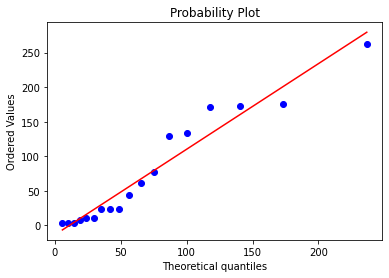

In [ ]:
params = ss.expon.fit(hit_deltas)
ss.probplot(hit_deltas, dist=ss.expon(*params), plot=plt);

Another example. Assume we have monthly records of losses incurred that month and monthly 90%-VaR estimations for the 1-month horizon (for the next month).

In [ ]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
losses = [10, 11, 12, 11, 10, 9, 11, 13, 11, 9, 8, 9]
VaRs_3m_ahead = [9.5, 9, 8.5, 9, 9.5, 10.5, 9, 10, 11, 12, 11, 10]

df = pd.DataFrame({"Month": months, "Losses": losses, "VaR": VaRs_3m_ahead})
df = df.set_index("Month")
#print(df.to_string(index=False))
print(df)

       Losses   VaR
Month              
Jan        10   9.5
Feb        11   9.0
Mar        12   8.5
Apr        11   9.0
May        10   9.5
Jun         9  10.5
Jul        11   9.0
Aug        13  10.0
Sep        11  11.0
Oct         9  12.0
Nov         8  11.0
Dec         9  10.0


In [ ]:
# Make sure we compare correct numbers
pd.concat([df['Losses'], df['VaR'].shift(1)], axis=1)

,Losses,VaR
Month,,
Jan,10,NaN
Feb,11,9.5
Mar,12,9.0
Apr,11,8.5
May,10,9.0
Jun,9,9.5
Jul,11,10.5
Aug,13,9.0
Sep,11,10.0


In [ ]:
hits = df['Losses'] > df['VaR'].shift(1)
# this is bad... We don't have an observation for Jan!!!
hits

Month
Jan    False
Feb     True
Mar     True
Apr     True
May     True
Jun    False
Jul     True
Aug     True
Sep     True
Oct    False
Nov    False
Dec    False
dtype: bool

In [ ]:
# This is wrong: we forgot about NaNs!
n = hits.sum()
N = hits.size
N, n

(12, 7)

In [ ]:
# NaNs are tricky...
a = b = np.nan
print(b == a, a >= b, a <= b)
print(a==a)

False False False
False


In [ ]:
# This is better...
df['VaR'] = df['VaR'].shift(1)
df.dropna(inplace=True)
hits = df['Losses'] > df['VaR']
n = hits.sum()
N = hits.size
N, n

(11, 7)

Now what would happen if these were VaR predictions for the losses during the next 3 months?

(hint: just shifting by 3 would not be enough...)

In [ ]:
print(pd.concat([df['Losses'], df['VaR'].shift(3)], axis=1))

       Losses   VaR
Month              
Jan        10   NaN
Feb        11   NaN
Mar        12   NaN
Apr        11   9.5
May        10   9.0
Jun         9   8.5
Jul        11   9.0
Aug        13   9.5
Sep        11  10.5
Oct         9   9.0
Nov         8  10.0
Dec         9  11.0


## Class Problems

1. Риск-аналитик построил модель для оценки VaR для недавно выпущенной криптовалюты RM-Coin. К сожалению, исторический ряд её доходностей составляет чуть менее 1.5 года (350 наблюдений). Так как модель использует первые 250 наблюдений для оценки параметров, эффективная длина ряда для бэктестинга составит всего 100 наблюдений, что маловато.

    Для того, чтобы увеличить количество точек для бэктеста, аналитик использует котировки курса этой криптовалюты к 10 другим валютам. Для каждого из 10 рядов параметры модели оцениваются отдельно под этот конкретный ряд. После этого мы получаем 10 рядов по 100 точек -- всего 1000 точек. Таким образом, для проверки итоговой гипотезы он использует суммарное количество пробитий на этих 10 рядах и их суммарную длину (1000).

    Соблюдены ли предпосылки биномиального теста?

2. Модель 1-дневного VaR валидировалась на горизонте 250 торговых дней. Однако в связи с резким ухудшением рыночной обстановки и возросшими опасениями в корректности модели, риск-менеджер решил увеличить горизонт валидации в 5 раз -- до 1250 торговых дней.

Какое влияние это окажет на бэктестинг и на вероятность обнаружения проблем в модели?


3. Даны ежедневные котировки индекса и оценки VaR на уровне 95% в базисных пунктах (0.01%) по нему на горизонте 1 день. Проведите бэктест. Отдельно укажите количество пробоев и количество наблюдений для биномиального теста.

In [ ]:
np.random.seed(14)
index_quotes = pd.Series(1700 + np.cumsum(np.random.randint(-10, 10, size=88)), index=pd.period_range(end="2021-09-01", periods=88, freq="B"))
assert index_quotes.iloc[0] == 1701, "Something is wrong! Contact the teacher"
print(index_quotes)

np.random.seed(88)
VaRs = pd.Series(50 + np.random.randint(-10, 10, size=70), index=pd.period_range(end="2021-09-09", periods=70, freq="B"))
assert VaRs.iloc[0] == 40, "Something is wrong! Contact the teacher"
print(VaRs)


2021-05-03    1701
2021-05-04    1703
2021-05-05    1700
2021-05-06    1696
2021-05-07    1696
              ... 
2021-08-26    1671
2021-08-27    1672
2021-08-30    1663
2021-08-31    1666
2021-09-01    1672
Freq: B, Length: 88, dtype: int64
2021-06-04    40
2021-06-07    55
2021-06-08    57
2021-06-09    50
2021-06-10    45
              ..
2021-09-03    46
2021-09-06    54
2021-09-07    56
2021-09-08    59
2021-09-09    56
Freq: B, Length: 70, dtype: int64


In [ ]:
df1 = pd.DataFrame({'a':index_quotes.pct_change()}, index=index_quotes.index)
df2 = pd.DataFrame({'b':VaRs*0.0001}, index=VaRs.index)

df = pd.merge(df1, df2, left_index=True, right_index=True)
df.dropna(inplace=True)

hits = df['a'] < -df['b']

N = hits.size
n = hits.sum()
N, n

(64, 6)

# Risk Measure Estimation

In [ ]:
quotes = yf.download("AAPL", "2016-01-01", "2020-12-31")
prices = quotes['Adj Close']
returns = prices.pct_change().dropna().rename('Returns')
returns

[*********************100%***********************]  1 of 1 completed


Date
2016-01-05   -0.025059
2016-01-06   -0.019570
2016-01-07   -0.042205
2016-01-08    0.005288
2016-01-11    0.016192
                ...   
2020-12-23   -0.006976
2020-12-24    0.007712
2020-12-28    0.035766
2020-12-29   -0.013315
2020-12-30   -0.008527
Name: Returns, Length: 1257, dtype: float64

We need stationary data for our analysis. Let's see what's stationary...

<AxesSubplot:xlabel='Date'>

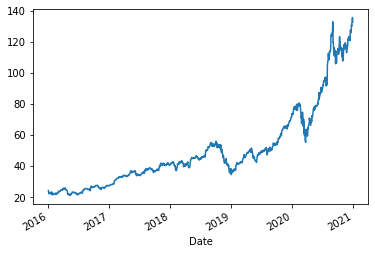

In [ ]:
prices.plot()

Maybe take first differences...

<AxesSubplot:xlabel='Date'>

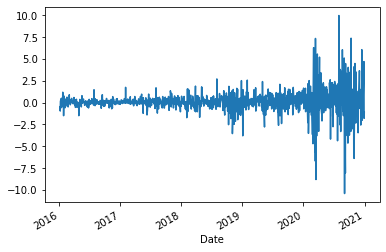

In [ ]:
prices.diff().plot()

Returns look more stationary...

<AxesSubplot:xlabel='Date'>

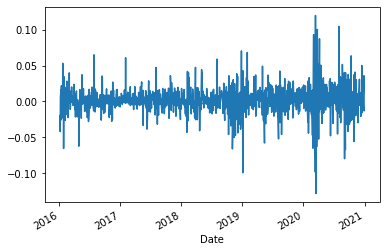

In [ ]:
prices.pct_change().plot()

In [ ]:
# VaR level
alpha = 0.99

Note the formula for VaR:

$$
VaR_\gamma=\sup\{x:\,P(\text{Loss}\geq x)>1-\gamma\}=\inf\{x:F_{\text{Loss}}(x)\geq \gamma\}
$$

$$
VaR_\gamma=-\inf\{x:\,P(\text{P\&L}\leq x)>1-\gamma\}=-\inf\{x:F_{\text{P\&L}}(x)> 1-\gamma\}
$$

In [ ]:
def calculate_VaR_HS(returns, alpha):
    return np.quantile(returns.values, method='inverse_cdf')

In [ ]:
PnL = pd.Series(range(-10, 0))
print(PnL)
print(calculate_VaR_HS(PnL, 0.89), calculate_VaR_HS(PnL, 0.90), calculate_VaR_HS(PnL, 0.91))

0   -10
1    -9
2    -8
3    -7
4    -6
5    -5
6    -4
7    -3
8    -2
9    -1
dtype: int64


TypeError: _quantile_dispatcher() missing 1 required positional argument: 'q'

In [ ]:
PnL = pd.Series(range(-10, 0))
print(PnL)
print(calculate_VaR_HS(PnL, 0.89), calculate_VaR_HS(PnL, 0.90), calculate_VaR_HS(PnL, 0.91))

0   -10
1    -9
2    -8
3    -7
4    -6
5    -5
6    -4
7    -3
8    -2
9    -1
dtype: int64
9 10 10


In [ ]:
calculate_VaR_HS(returns, alpha)

0.056018111245177526

Apply it to the rolling window

In [ ]:
def calc_VaR(returns, VaR_fun, window_length, VaR_level):
    
    raise NotImplementedError()

In [ ]:
from functools import partial

def calc_VaR(returns, VaR_fun, window_length, VaR_level):
    if VaR_fun == calculate_VaR_HS:
        VaR_fun = partial(VaR_fun, alpha = VaR_level)
    return returns.rolling(window_length).apply(VaR_fun)

In [ ]:
a = pd.Series([0,1,2,3,4,5,6,5,4,3,2,1,0])
t1 = calc_VaR(a, VaR_fun=lambda x: max(x), window_length=4, VaR_level=0.99)
t2 = calc_VaR(a, VaR_fun=calculate_VaR_HS, window_length=4, VaR_level=0.75)
print(pd.DataFrame({'Data': a, 'Rolling Max': t1, 'Rolling Min': t2}))

    Data  Rolling Max  Rolling Min
0      0          NaN          NaN
1      1          NaN          NaN
2      2          NaN          NaN
3      3          3.0        -0.75
4      4          4.0        -1.75
5      5          5.0        -2.75
6      6          6.0        -3.75
7      5          6.0        -4.75
8      4          6.0        -4.75
9      3          6.0        -3.75
10     2          5.0        -2.75
11     1          4.0        -1.75
12     0          3.0        -0.75


In [ ]:
a = pd.Series([0,1,2,3,4,5,6,5,4,3,2,1,0])
t1 = calc_VaR(a, VaR_fun=lambda x,y: max(x), window_length=4, VaR_level=0.99)
t2 = calc_VaR(a, VaR_fun=calculate_VaR_HS, window_length=4, VaR_level=0.75)
print(pd.DataFrame({'Data': a, 'Rolling Max': t1, 'Rolling Min': t2}))

    Data  Rolling Max  Rolling Min
0      0          NaN          NaN
1      1          NaN          NaN
2      2          NaN          NaN
3      3          NaN          NaN
4      4          3.0          0.0
5      5          4.0         -1.0
6      6          5.0         -2.0
7      5          6.0         -3.0
8      4          6.0         -4.0
9      3          6.0         -4.0
10     2          6.0         -3.0
11     1          5.0         -2.0
12     0          4.0         -1.0


In [ ]:
VaR_HS = calc_VaR(returns, calculate_VaR_HS, 252, alpha)
VaR_HS

Date
2016-01-04         NaN
2016-01-05         NaN
2016-01-06         NaN
2016-01-07         NaN
2016-01-08         NaN
                ...   
2020-12-23    0.080061
2020-12-24    0.080061
2020-12-28    0.080061
2020-12-29    0.080061
2020-12-30    0.080061
Name: calculate_VaR_HS, Length: 1258, dtype: float64

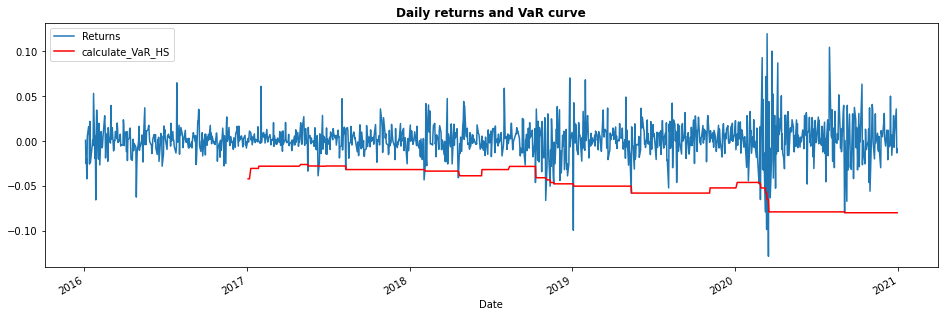

In [ ]:
fig = plt.figure(figsize=(16, 5))

returns.plot()
(-VaR_HS).plot(color="r")

plt.title("Daily returns and VaR curve", weight="bold")
plt.legend()
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=dc69f171-f4bb-4c21-8857-3bf9aef78ad4' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>